# Poisson equation in 1D with Dirichlet boundary conditions

## Problem setup

We will solve a Poisson equation:
$$
-\nabla^2 u = \pi^2 \sin(\pi x), \qquad x \in [-1, 1],
$$
with the Dirichlet boundary conditions
$$
u(-1) = 0, \quad u(1) = 0.
$$

The exact solution is $u(x) = \sin(\pi x)$.

## Implementation

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['DDE_BACKEND'] = 'tensorflow'

In [ ]:
import deepxde as dde
from deepxde.backend import tf
import numpy as np
import matplotlib.pyplot as plt

We define a computational geometry.

In [ ]:
geom = dde.geometry.Interval(-1, 1)

We express the PDE residual.

The first argument to `pde` is the network input, i.e., the $x$-coordinate. The second argument is the network output, i.e., the solution $u(x)$.

In [ ]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    return -dy_xx - np.pi**2 * tf.sin(np.pi*x)

A simple Python function, returning a boolean, which is used to define the subdomain (${-1, 1}$) for the Dirichelt boundary condition. The function should return `True` for those points inside the subdomain and `False` for the points outside.

The first argument `x` to `boundary` is the network input and is a $d$-dim vector, where $d$ is the dimension and $d=1$ in this case. To facilitate the implementation of `boundary`, a boolean `on_boundary` is used as the second argument. If the point `x` (the first argument) is on the entire boundary of the geometry, then `on_boundary` is `True`, otherwise, `on_boundary` is `False`.

In [ ]:
# def boundary(x, _):
#     return dde.utils.isclose(x[0], -1) or dde.utils.isclose(x[0], 1)

def boundary(x, on_boundary):
    return on_boundary

We define a function to return the value of $u(x)$ for the points $x$ on the boundary.

In [ ]:
def func(x):
    return 0

If the function value is not a constant, we can also use NumPy to compute, For example, $sin(\pi x)$ is 0 on the boundary, and thus we can also use

In [ ]:
def func(x):
    return np.sin(np.pi * x)

Then, the Dirichelt boundary condition is

In [ ]:
bc = dde.icbc.DirichletBC(geom, func, boundary)

Now, we have specified the geometry, PDE residual, and Dirichlet boundary condition. We then define the PDE problem as

In [ ]:
data = dde.data.PDE(geom, 
                    pde, 
                    bc,
                    num_domain=16,
                    num_boundary=2,
                    solution=func,
                    num_test=100)

The number 16 is the number of training points sampled inside the domain, and the number 2 is the number of training points sampled on the boundary.

Here, we use a fully connected neural network of depth 4 (i.e., 3 hidden layers) and width 50:

In [ ]:
layer_size = [1] + [50] * 3 + [1]
layer_size

[1, 50, 50, 50, 1]

In [ ]:
activation = "tanh"
initializer = "Glorot uniform"

net = dde.nn.FNN(layer_size, activation, initializer)

2023-10-09 08:13:36.493604: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-10-09 08:13:36.494513: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10520 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:82:00.0, compute capability: 7.0


We build a `model` and choose the optimizer and learning rate.

We also compute the $L^2$ relative error as a metric during training.

In [ ]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

Compiling model...
'compile' took 0.016701 s



In [ ]:
loss_histroy, train_state = model.train(iterations=10000)

Training model...



/userhome/jeon_mg/miniforge3/envs/pinn_tf/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2023-10-09 08:15:48.290996: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55b6044408b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-09 08:15:48.291049: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN V, Compute Capability 7.0
2023-10-09 08:15:48.301683: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-09 08:15:49.222494: I tensorflow/compiler

Step      Train loss              Test loss               Test metric   
0         [4.33e+01, 1.37e-02]    [4.89e+01, 1.37e-02]    [9.25e-01]    
1000      [7.44e-04, 1.77e-06]    [6.39e-04, 1.77e-06]    [9.94e-04]    
2000      [1.70e-04, 2.27e-08]    [2.54e-04, 2.27e-08]    [1.82e-04]    
3000      [6.90e-04, 3.73e-05]    [4.94e-04, 3.73e-05]    [4.91e-03]    
4000      [5.87e-05, 1.24e-06]    [1.00e-04, 1.24e-06]    [9.99e-04]    
5000      [2.24e-04, 1.22e-05]    [2.15e-04, 1.22e-05]    [3.55e-03]    
6000      [3.48e-04, 5.24e-06]    [3.08e-04, 5.24e-06]    [2.63e-03]    
7000      [3.45e-05, 5.28e-07]    [6.43e-05, 5.28e-07]    [7.43e-04]    
8000      [3.56e-03, 7.35e-05]    [3.77e-03, 7.35e-05]    [7.69e-03]    
9000      [5.08e-05, 5.72e-07]    [7.35e-05, 5.72e-07]    [6.95e-04]    
10000     [2.11e-05, 3.68e-07]    [4.44e-05, 3.68e-07]    [5.93e-04]    

Best model at step 10000:
  train loss: 2.14e-05
  test loss: 4.47e-05
  test metric: [5.93e-04]

'train' took 20.478300 s


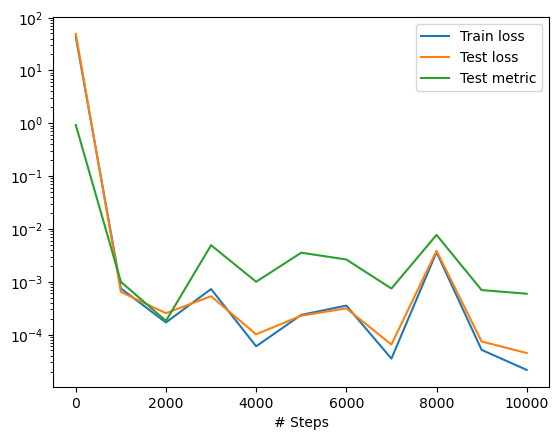

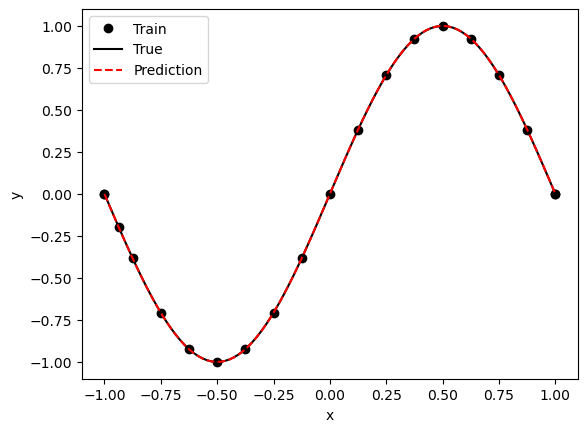

In [ ]:
dde.saveplot(loss_histroy, train_state, issave=False, isplot=True)